In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl

plt.style.use(["seaborn", "thesis"])

In [3]:
plt.rc("figure", figsize=(8,4))

# Data 

In [4]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"
basis = "6-311++g**"

data = Data()
data.include(data_path = "../../thesis/dataset/EthanT/", postfix = "EthanT", target=target)

In [189]:
from SCFInitialGuess.utilities.dataset import Molecule

angle_HCC = 121.3/180 *np.pi
distance_CC = 1.339
distance_CH = 1.087

mol = Molecule(
    species=["C", "C", "H", "H", "H", "H"],
    positions=[
        [ 0.00000,       0.00000,        0.00000],
        [ distance_CC  ,       0.00000,        0.00000],
        [ distance_CH * np.cos(angle_HCC), distance_CH * np.sin(angle_HCC), 0.00000],
        [ distance_CH * np.cos(2*np.pi - angle_HCC), distance_CH * np.sin(2*np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(np.pi - angle_HCC), distance_CH * np.sin(np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(- np.pi + angle_HCC), distance_CH * np.sin(- np.pi + angle_HCC), 0.00000]
    ]
)

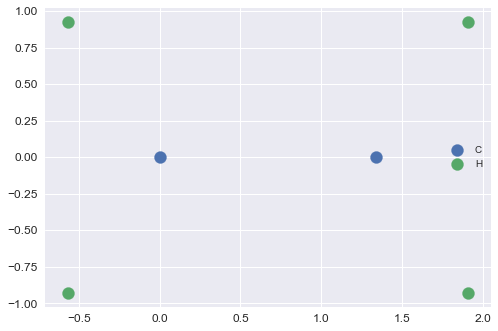

In [190]:
#%matplotlib inline

pos = np.array(mol.positions)

plt.scatter(pos[:2, 0], pos[:2, 1], label="C")
plt.scatter(pos[2:, 0], pos[2:, 1], label="H")
plt.legend()

# Descriptor 

In [191]:
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    SphereSectionDescriptor, ConstantAngularDescriptor, Gaussians
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import make_uniform

model = make_uniform(8, R_c=5)

radial = Gaussians(*model)

descriptor = AtomicNumberWeighted(
    ConstantAngularDescriptor(),
    SphereSectionDescriptor(
        number_azimuthal_sections=8,
        number_polar_sections=4,
        radial_descriptor=radial
    ),
    BehlerCutoff1(5)
)
    

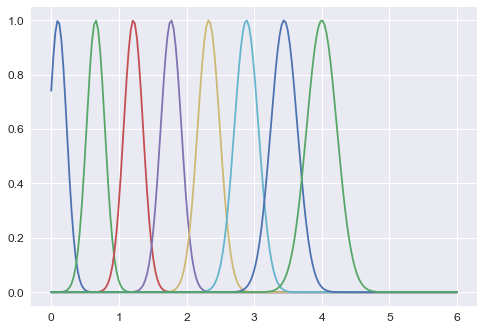

In [192]:
from SCFInitialGuess.descriptors.utilities import plot_normal_model

#%matplotlib inline

plot_normal_model(model, np.linspace(0, 6, 200))

# Calculate Dataset for C

In [193]:
G = descriptor.calculate_atom_descriptor(
    index_atom=0, 
    molecule=mol, 
    number_of_descriptors=descriptor.number_of_descriptors
)

# Activation 

In [194]:
n = 100

r = np.linspace(0, 6, n)
phi = np.linspace(0, 2*np.pi, n)
theta = np.pi/2

R, Phi = np.meshgrid(r, phi)

R = R.reshape(-1)
Phi = Phi.reshape(-1)

## Radial 

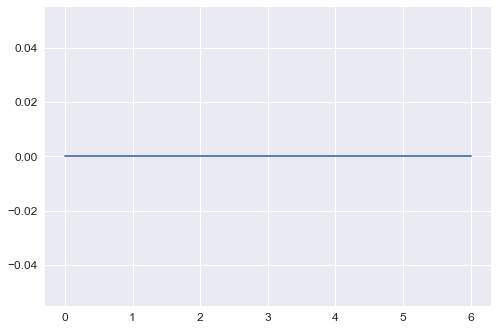

In [195]:
plt.plot(r, descriptor.angular_descriptor.calculate_inverse_descriptor(r, phi=0.0, theta=np.pi/2, y=G).reshape(-1))

## Angles, z=0

In [196]:
R.shape, Phi.shape

((10000,), (10000,))

In [197]:
z = descriptor.angular_descriptor.calculate_inverse_descriptor(
    r=r, 
    phi=phi, 
    theta=theta, 
    y=G
)#.reshape(-1)

z[z==0] = 1e-20

z.shape

(1, 100, 100)

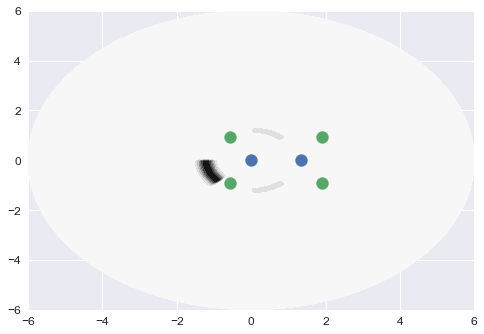

In [199]:
plt.contourf(
    (R * np.cos(Phi)).reshape(n, n),
    (R * np.sin(Phi)).reshape(n, n),
    z.reshape(n, n),
    #locator=mpl.ticker.LogLocator()
)

plt.scatter(pos[:2, 0], pos[:2, 1], label="C")
plt.scatter(pos[2:, 0], pos[2:, 1], label="H")


## Angles, Spheres 

In [163]:
n = 100

r = 0.9
phi = np.linspace(0, 2*np.pi, n)
theta = np.linspace(0, np.pi, n)

Phi, Theta = np.meshgrid(phi, theta)

In [164]:
z = descriptor.angular_descriptor.calculate_inverse_descriptor(
    r=r, 
    phi=phi, 
    theta=theta, 
    y=G
)#.reshape(-1)

z[z==0] = 1e-20

z.shape

(100, 100, 1)

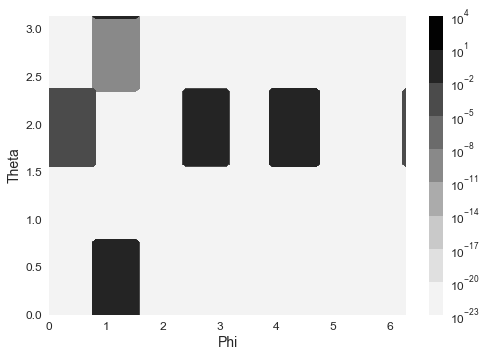

In [165]:
plt.contourf(
    Phi, 
    Theta,
    z.reshape(n, n),
    locator=mpl.ticker.LogLocator()
)
plt.xlabel("Phi")
plt.ylabel("Theta")
plt.colorbar()

In [166]:
#%matplotlib notebook

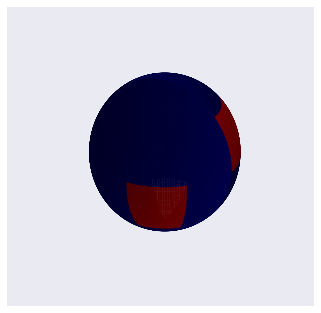

In [167]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

fcolors = z.reshape(n,n)
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

x = np.sin(Phi) * np.cos(Theta)
y = np.sin(Phi) * np.sin(Theta)
z = np.cos(Phi)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    x, 
    y, 
    z,  
    rstride=1, 
    cstride=1, 
    facecolors=cm.seismic(fcolors)
)
# Turn off the axis planes
ax.set_axis_off()
plt.show()

# Calculate The Dataset 

In [168]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset

dataset = make_center_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "C"
)

In [169]:
dataset.testing[0][0].shape, dataset.testing[1].shape

((256,), (402, 253))

# Visualize The Descriptor 

In [170]:
from SCFInitialGuess.utilities.dataset import AbstractDataset

x_train = AbstractDataset.denormalize(dataset_C.training[0], dataset_C.x_mean, dataset_C.x_std)
y_train = dataset_C.training[1]
np.mean(x_train[0] - x_train[-1])

-0.0005549558294328037

## Varaince

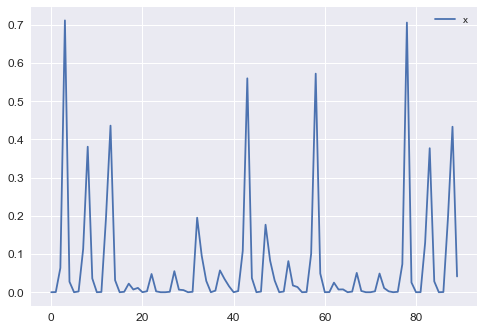

In [171]:
offset=0
plt.plot(np.var(x_train, 0)[offset:], label="x")
#plt.plot([descriptor.radial_descriptor.number_of_descriptors - offset]*2, [1e-3, 1.6], "--")

plt.legend()

## Average 

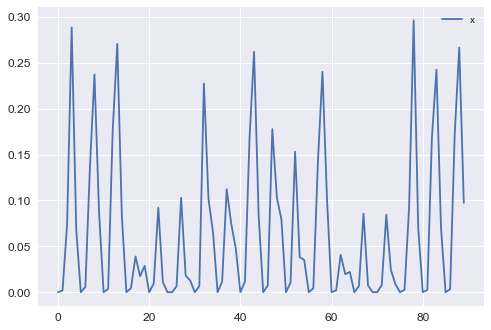

In [172]:
plt.plot(np.mean(x_train, 0), label="x")
#plt.plot([descriptor.radial_descriptor.number_of_descriptors]*2, [-0.25, 0.25], "--")

plt.legend()

## PCA 

# Try to Learn

## Utils 

In [173]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(5e-3)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [174]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath, learning_rate=1e-4, log_dir="./logs"):

    
    tensorboard = keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=0, 
        batch_size=32, 
        #update_freq='epoch'
    )
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_mean_squared_error', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1
    )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                #checkpoint,
                #tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

## Setup network 

In [175]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(1280, 320, 402)

In [176]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

species = "C"

dim = N_BASIS[basis][species]
dim_triu = dim * (dim + 1) // 2

descriptor.number_of_descriptors, dim_triu

(256, 253)

In [177]:
keras.backend.clear_session()

In [178]:
structure = [descriptor.number_of_descriptors, dim_triu, dim_triu]

model = make_model(
    structure=structure,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_triu,
    
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 253)               65021     
_________________________________________________________________
dense_2 (Dense)              (None, 253)               64262     
_________________________________________________________________
dense_3 (Dense)              (None, 253)               64262     
Total params: 259,337
Trainable params: 259,337
Non-trainable params: 0
_________________________________________________________________


## Train network 

Train on 1280 samples, validate on 320 samples
Epoch 1/1000
1280/1280 [==============================] - 0s 275us/sample - loss: 0.0410 - mean_squared_error: 0.0061 - val_loss: 0.0284 - val_mean_squared_error: 0.0057
Epoch 2/1000
1280/1280 [==============================] - 0s 119us/sample - loss: 0.0208 - mean_squared_error: 0.0050 - val_loss: 0.0147 - val_mean_squared_error: 0.0045
Epoch 3/1000
1280/1280 [==============================] - 0s 114us/sample - loss: 0.0105 - mean_squared_error: 0.0034 - val_loss: 0.0082 - val_mean_squared_error: 0.0034
Epoch 4/1000
1280/1280 [==============================] - 0s 114us/sample - loss: 0.0051 - mean_squared_error: 0.0015 - val_loss: 0.0053 - val_mean_squared_error: 0.0028
Epoch 5/1000
1280/1280 [==============================] - 0s 124us/sample - loss: 0.0026 - mean_squared_error: 7.9791e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0022
Epoch 6/1000
1280/1280 [==============================] - 0s 118us/sample - loss: 0.0015 - mean_squ

 928/1280 [====================>.........] - ETA: 0s - loss: 2.2170e-04 - mean_squared_error: 2.2165e-04
Epoch 00040: ReduceLROnPlateau reducing learning rate to 1e-10.
1280/1280 [==============================] - 0s 123us/sample - loss: 2.2005e-04 - mean_squared_error: 2.2000e-04 - val_loss: 2.1674e-04 - val_mean_squared_error: 2.1669e-04
Epoch 41/1000
1280/1280 [==============================] - 0s 117us/sample - loss: 2.2005e-04 - mean_squared_error: 2.2000e-04 - val_loss: 2.1674e-04 - val_mean_squared_error: 2.1669e-04
Epoch 42/1000
1280/1280 [==============================] - 0s 161us/sample - loss: 2.2005e-04 - mean_squared_error: 2.2000e-04 - val_loss: 2.1674e-04 - val_mean_squared_error: 2.1669e-04
Epoch 43/1000
1280/1280 [==============================] - 0s 117us/sample - loss: 2.2005e-04 - mean_squared_error: 2.2000e-04 - val_loss: 2.1674e-04 - val_mean_squared_error: 2.1669e-04
Epoch 44/1000
1056/1280 [=======================>......] - ETA: 0s - loss: 2.1488e-04 - mean_squa

 896/1280 [====================>.........] - ETA: 0s - loss: 2.2368e-04 - mean_squared_error: 2.2331e-04
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1280/1280 [==============================] - 0s 121us/sample - loss: 2.2107e-04 - mean_squared_error: 2.2068e-04 - val_loss: 2.1836e-04 - val_mean_squared_error: 2.1801e-04
Epoch 6/1000
1280/1280 [==============================] - 0s 114us/sample - loss: 2.2049e-04 - mean_squared_error: 2.2035e-04 - val_loss: 2.1682e-04 - val_mean_squared_error: 2.1676e-04
Epoch 7/1000
1280/1280 [==============================] - 0s 141us/sample - loss: 2.2017e-04 - mean_squared_error: 2.2013e-04 - val_loss: 2.1673e-04 - val_mean_squared_error: 2.1669e-04
Epoch 8/1000
1280/1280 [==============================] - 0s 127us/sample - loss: 2.2012e-04 - mean_squared_error: 2.2010e-04 - val_loss: 2.1683e-04 - val_mean_squared_error: 2.1681e-04
Epoch 9/1000
 928/1280 [====================>.........] - ETA: 0s - loss: 2.1862e-04

Epoch 19/1000
1280/1280 [==============================] - 0s 127us/sample - loss: 2.1995e-04 - mean_squared_error: 2.1995e-04 - val_loss: 2.1653e-04 - val_mean_squared_error: 2.1653e-04
Epoch 20/1000
1280/1280 [==============================] - 0s 123us/sample - loss: 2.1995e-04 - mean_squared_error: 2.1995e-04 - val_loss: 2.1653e-04 - val_mean_squared_error: 2.1653e-04
Epoch 21/1000
1280/1280 [==============================] - 0s 116us/sample - loss: 2.1995e-04 - mean_squared_error: 2.1995e-04 - val_loss: 2.1653e-04 - val_mean_squared_error: 2.1653e-04
Epoch 22/1000
1088/1280 [========================>.....] - ETA: 0s - loss: 2.2102e-04 - mean_squared_error: 2.2102e-04
Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
1280/1280 [==============================] - 0s 113us/sample - loss: 2.1995e-04 - mean_squared_error: 2.1995e-04 - val_loss: 2.1653e-04 - val_mean_squared_error: 2.1653e-04
Epoch 23/1000
1280/1280 [==============================] - 0s 116us

Epoch 9/1000
1280/1280 [==============================] - 0s 181us/sample - loss: 2.2002e-04 - mean_squared_error: 2.1999e-04 - val_loss: 2.1664e-04 - val_mean_squared_error: 2.1662e-04
Epoch 10/1000
1280/1280 [==============================] - 0s 170us/sample - loss: 2.1999e-04 - mean_squared_error: 2.1998e-04 - val_loss: 2.1661e-04 - val_mean_squared_error: 2.1660e-04
Epoch 11/1000
1280/1280 [==============================] - 0s 168us/sample - loss: 2.1998e-04 - mean_squared_error: 2.1997e-04 - val_loss: 2.1659e-04 - val_mean_squared_error: 2.1659e-04
Epoch 12/1000
1088/1280 [========================>.....] - ETA: 0s - loss: 2.1975e-04 - mean_squared_error: 2.1975e-04
Epoch 00012: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
1280/1280 [==============================] - 0s 167us/sample - loss: 2.1998e-04 - mean_squared_error: 2.1997e-04 - val_loss: 2.1655e-04 - val_mean_squared_error: 2.1655e-04
Epoch 13/1000
1280/1280 [==============================] - 0s 185us/

1280/1280 [==============================] - 0s 129us/sample - loss: 2.1995e-04 - mean_squared_error: 2.1995e-04 - val_loss: 2.1661e-04 - val_mean_squared_error: 2.1661e-04
Epoch 19/1000
1280/1280 [==============================] - 0s 128us/sample - loss: 2.1995e-04 - mean_squared_error: 2.1995e-04 - val_loss: 2.1661e-04 - val_mean_squared_error: 2.1661e-04
Epoch 20/1000
1120/1280 [=========================>....] - ETA: 0s - loss: 2.1754e-04 - mean_squared_error: 2.1754e-04
Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
1280/1280 [==============================] - 0s 152us/sample - loss: 2.1995e-04 - mean_squared_error: 2.1995e-04 - val_loss: 2.1661e-04 - val_mean_squared_error: 2.1661e-04
Epoch 21/1000
1280/1280 [==============================] - 0s 133us/sample - loss: 2.1995e-04 - mean_squared_error: 2.1995e-04 - val_loss: 2.1661e-04 - val_mean_squared_error: 2.1661e-04
Epoch 22/1000
1280/1280 [==============================] - 0s 122us/sample - loss

KeyboardInterrupt: 

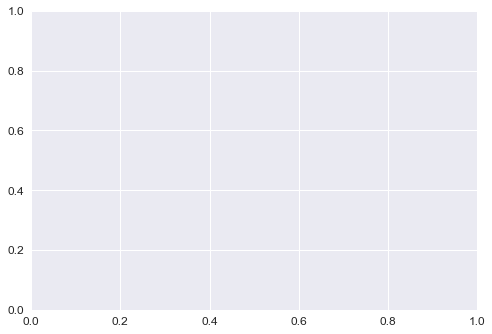

In [179]:
#i+=1
train_model(
    model, 
    dataset, 
    None,#model_path + name_folder,
    learning_rate=1e-4,
    log_dir=None#"./logs/H/" + name + "_" + "x".join(list(map(str, structure))) + "_" + str(i)
)